In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from energy_consumption.feature_selection.extract import extract_energy_data
from energy_consumption.feature_selection.collect import dummy_mapping

In [2]:
# create dummies for season and day in the week
energydata = extract_energy_data.get_data(num_years=5)

100%|██████████| 260/260 [02:46<00:00,  1.56it/s]


In [4]:
energydata1 = dummy_mapping.get_season_mapping(energydata)
energydata2 = dummy_mapping.get_day_mapping(energydata1)

DatetimeIndex(['2019-01-21 00:00:00', '2019-01-21 01:00:00',
               '2019-01-21 02:00:00', '2019-01-21 03:00:00',
               '2019-01-21 04:00:00', '2019-01-21 05:00:00',
               '2019-01-21 06:00:00', '2019-01-21 07:00:00',
               '2019-01-21 08:00:00', '2019-01-21 09:00:00',
               ...
               '2024-01-03 03:00:00', '2024-01-03 04:00:00',
               '2024-01-03 05:00:00', '2024-01-03 06:00:00',
               '2024-01-03 07:00:00', '2024-01-03 08:00:00',
               '2024-01-03 09:00:00', '2024-01-03 10:00:00',
               '2024-01-03 11:00:00', '2024-01-03 12:00:00'],
              dtype='datetime64[ns]', name='date_time', length=43405, freq='H')

### Map hours 
* to 3 different classes within the day
* find best classes through unsupervised learning
* for unsupervised learning algo, delete "outliers"


1. Impute missing data and create desired frame

In [5]:
from datetime import datetime
ec = energydata2[['energy_consumption']]
ec['hour'] = ec.index.hour
ec['date'] = ec.index.date

e_per_hour = ec.pivot(
    index='date', columns='hour', values='energy_consumption')

# Rename the columns to indicate the hour with "ec_h"
e_per_hour.columns = [f'ec{hour}' for hour in e_per_hour.columns]


In [6]:
# impute missing data of last row by last weeks ec (7 days ahead)
# ! iloc index needs to be changed to -7 after 12am
nan_columns = e_per_hour.columns[e_per_hour.iloc[-7].isna()]
imputation_values = e_per_hour.iloc[-8, :].loc[nan_columns]

# Replace NaN values in the last row with corresponding imputation values
e_per_hour.loc[e_per_hour.index[-7], nan_columns] = imputation_values

Text(0, 0.5, 'Energy Consumption [GwH]')

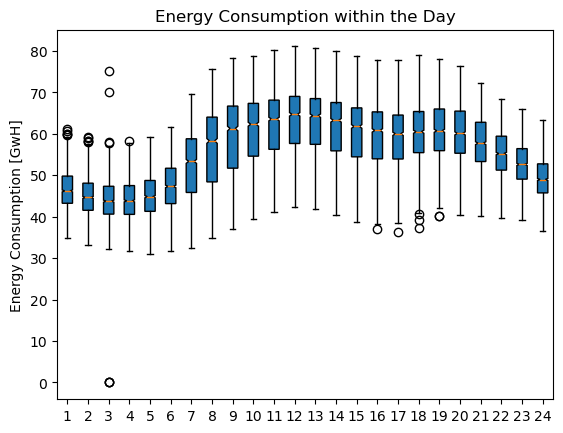

In [7]:
energy_array = np.array(e_per_hour[:-1])
plt.boxplot(energy_array, patch_artist=True, notch=True)
plt.title('Energy Consumption within the Day')
plt.ylabel("Energy Consumption [GwH]")

#Auffällig: Outlier

Found outliers --> delete them <br>
*Note*: Outliers follow a pattern --> consider later

In [8]:
from sklearn.neighbors import LocalOutlierFactor

e_per_hour_train = e_per_hour[:-1]

clf = LocalOutlierFactor(n_neighbors=20)

y_pred = clf.fit_predict(e_per_hour_train)


# Get the outlier scores 

X_scores = clf.negative_outlier_factor_


# Find the indices of the rows with the biggest outliers 

top_outliers_indices = X_scores.argsort()[:20]


# Get the rows with the biggest outliers

top_outliers_rows = e_per_hour_train.iloc[top_outliers_indices]


# Display the rows with the biggest outliers

print("Rows with the biggest outliers:")

print(top_outliers_rows.loc[:, 'ec2'])


print("\nOutlier scores:")

print(X_scores[top_outliers_indices])

c:\Users\Maria\Documents\Setups\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Maria\Documents\Setups\Lib\site-packages\joblib\externals\loky\backend\context.py", line 199, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Maria\Documents\Setups\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Maria\Documents\Setups\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Maria\Documents\Setups\Lib\subprocess.py", line 1538, in _execute_child
    h

Rows with the biggest outliers:
date
2023-03-26     0.00000
2022-03-27     0.00000
2022-10-30    70.08650
2021-03-28     0.00000
2023-10-29    75.17600
2023-05-28    32.49825
2022-01-01    40.48075
2023-04-09    35.29025
2022-01-06    52.55450
2020-01-01    41.48800
2020-01-02    41.92525
2021-11-30    54.17025
2021-02-14    52.79475
2023-01-01    37.10325
2021-02-13    55.65275
2021-01-06    50.04250
2024-01-01    37.10475
2023-05-19    35.39150
2021-01-01    41.11100
2023-05-29    32.20100
Name: ec2, dtype: float64

Outlier scores:
[-6.29701667 -5.54089267 -4.92335007 -4.65925305 -4.58184766 -2.16046493
 -1.97538213 -1.91175792 -1.89370287 -1.81954585 -1.76416152 -1.74023765
 -1.73477046 -1.73415851 -1.7139484  -1.64060878 -1.63869532 -1.63055868
 -1.6191297  -1.60576401]


Found four significant outliers --> delete these days 

ec0     46.673759
ec1     44.969655
ec2     44.105040
ec3     44.174700
ec4     45.081725
ec5     47.380274
ec6     52.386751
ec7     56.725089
ec8     59.670688
ec9     61.150378
ec10    62.363775
ec11    63.424866
ec12    63.038096
ec13    61.817547
ec14    60.466214
ec15    59.657789
ec16    59.271312
ec17    60.274774
ec18    60.835146
ec19    60.212113
ec20    57.825199
ec21    55.283182
ec22    52.823317
ec23    49.386919
dtype: float64

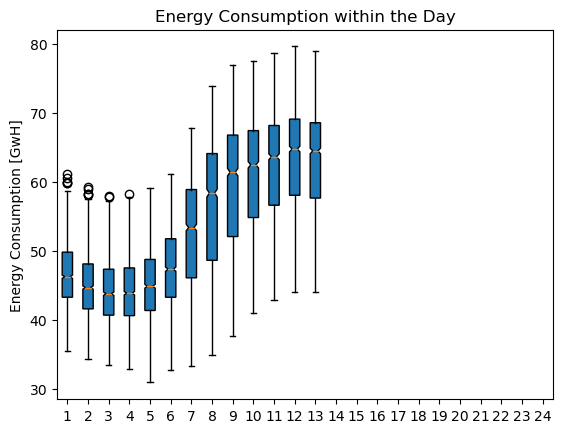

In [9]:
# Delete the rows with the biggest outliers from the original DataFrame
e_per_hour_filtered = e_per_hour.drop(e_per_hour.index[top_outliers_indices])

# plot boxplot with filtered data
energy_array_filtered = np.array(e_per_hour_filtered)
plt.boxplot(energy_array_filtered, patch_artist=True, notch=True)
plt.title('Energy Consumption within the Day')
plt.ylabel("Energy Consumption [GwH]")

e_per_hour_filtered.mean()

### Find time mappings 

1. Approach: Based on means and intervals of fixed length (current basis for seasonal_QR model)

In [10]:
column_means = e_per_hour_filtered.mean()
means_array = np.array(column_means)

max_mean = means_array.max()
min_mean = means_array.min()
interval_length = (max_mean-min_mean)/4

intervals = [min_mean+interval_length, 
     min_mean +2*interval_length, 
     min_mean+3*interval_length, 
     max_mean]

hour_mapping = {
    'lc': [],  # low consumption: between i[0] and i[1] 
    'mc': [],  # medium consumption: between i[1] and i[2]
    'hc': []   # high consumption: between i[2] and i[3]
}

for i in range(len(means_array)):

    col = str('ec' + str(i))
    col_mean = means_array[i]

    # low consumption
    if (col_mean > intervals[0]) & (col_mean <= intervals[1]):
        hour_mapping['lc'].append(col)
    elif (col_mean > intervals[1]) & (col_mean <= intervals[2]):
        hour_mapping['mc'].append(col)
    elif (col_mean > intervals[2]) & (col_mean <= intervals[3]):
        hour_mapping['hc'].append(col)
    else:
        print(col + ' in class of lowest consumption time')
    
hour_mapping 
# use this mappings
    

ec0 in class of lowest consumption time
ec1 in class of lowest consumption time
ec2 in class of lowest consumption time
ec3 in class of lowest consumption time
ec4 in class of lowest consumption time
ec5 in class of lowest consumption time


{'lc': ['ec6', 'ec22', 'ec23'],
 'mc': ['ec7', 'ec20', 'ec21'],
 'hc': ['ec8',
  'ec9',
  'ec10',
  'ec11',
  'ec12',
  'ec13',
  'ec14',
  'ec15',
  'ec16',
  'ec17',
  'ec18',
  'ec19']}

2. Approach: Clustering via K-means

c:\Users\Maria\Documents\Setups\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


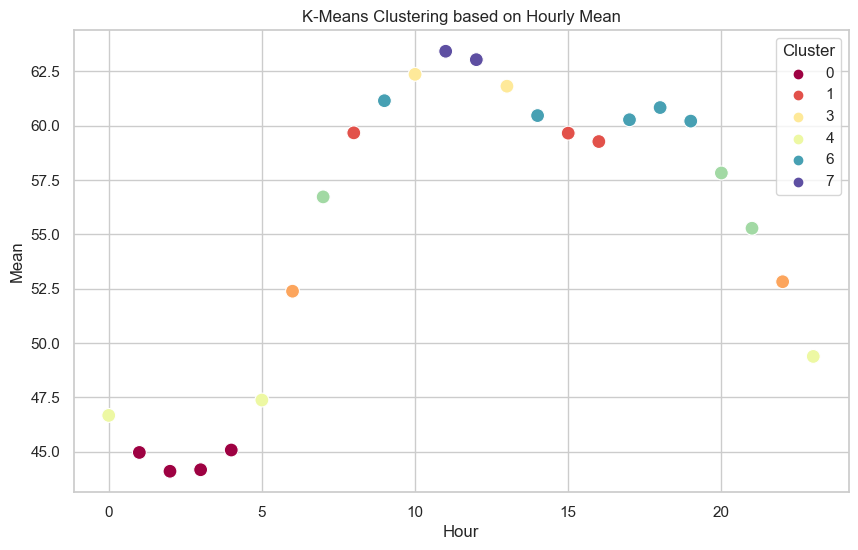

In [24]:
import seaborn as sns
from sklearn.cluster import KMeans




mean_df = pd.DataFrame(e_per_hour_filtered.mean())



kmeans = KMeans(n_clusters=8, max_iter=200, n_init="auto")


kmeans.fit(mean_df)


output = { 


    'hours': np.array([f'ec{h}' for h in range(24)]),


    'cluster': kmeans.predict(mean_df)


    }




kmeans_result = pd.DataFrame(output)


kmeans_result['mean'] = np.array(e_per_hour_filtered.mean())
kmeans_result

sns.set(style='whitegrid')

# Scatter plot with color based on 'cluster'
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    x='hours', y='mean', hue='cluster', data=kmeans_result, palette='Spectral', s=100)
positions = [0, 5, 10, 15, 20]
labels = ['0', '5', '10', '15', '20']
plt.xticks(positions, labels)

# Customize the plot
plt.title('K-Means Clustering based on Hourly Mean')
plt.xlabel('Hour')
plt.ylabel('Mean')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()